# Thrombolysis prediction shap

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from xgboost import XGBClassifier

## Load data

In [56]:
data = pd.read_csv('../data/thrombolysis_xgb_data_2017_2019.csv')

In [57]:
data.head()

,stroke team,age,infarction,stroke severity,onset-to-arrival time,precise onset known,onset during sleep,use of AF anticoagulants,prior disability,arrival-to-scan time,thrombolysis
0,Peterborough City Hospital,52.5,1,2,78,1,0,0,0,87.0,0
1,Royal Hampshire County Hospital,57.5,1,7,96,0,1,0,0,58.0,0
2,Basildon University Hospital,67.5,1,2,164,1,0,0,0,18.0,0
3,Withybush General Hospital,62.5,1,5,150,0,0,0,0,48.0,1
4,Fairfield General Hospital,87.5,1,2,65,1,0,0,4,7.0,0


## Split data into X and y

In [58]:
X = data.drop(['thrombolysis'], axis=1)
y = data['thrombolysis']

## Fit XGBoost model

In [59]:
# One hot encode hospitals
X_train_hosp = (pd.get_dummies(X['stroke team'], prefix='team'))
X_train = pd.concat([X, X_train_hosp], axis=1)
X_train.drop('stroke team', axis=1, inplace=True)

# Create XGBoost model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
model.fit(X_train, y)

# Get predictions
y_pred = model.predict(X_train)
y_pred_proba = model.predict_proba(X_train)[:, 1]
accuracy = np.mean(y_pred == y)
print(f'\nAccuracy: {accuracy:.3f}')


Accuracy: 0.886


## Get SHAP values

In [60]:
# Set up explainer using the model and feature values from training set
explainer = shap.TreeExplainer(model, X_train)

# GetShapley values along with base and feature values
shap_values_extended = explainer(X_train)
shap_values = shap_values_extended.values

100%|===================| 69468/69510 [02:21<00:00]        

## Summary SHAP plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


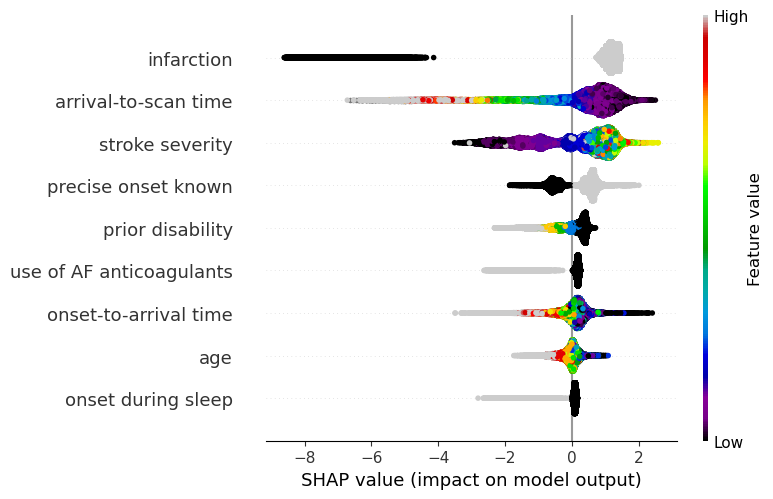

In [61]:
shap.summary_plot(
    shap_values=shap_values,
    features=X_train,
    max_display=9,
    cmap=plt.get_cmap('nipy_spectral'), show=False)


## Get hospital SHAP

In [62]:
# Get list of stroke teams
stroke_teams = X['stroke team'].unique()
stroke_teams.sort()

# Get mean SHAP for stroke team when patient attending that stroke team
stroke_team_mean_shap = dict()
# Loop through stroke teams
for stroke_team in stroke_teams:
    # Identify rows in test data that match each stroke team
    mask = X['stroke team'] == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = 'team_' + stroke_team
    index = list(X_train).index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Store median SHAP value for stroke team
    stroke_team_mean_shap[stroke_team] = np.median(stroke_team_shap)

In [63]:
stroke_team_shap_df = pd.DataFrame.from_dict(
    stroke_team_mean_shap, orient='index', columns=['shap'])

stroke_team_shap_df['odds_ratio'] = np.exp(stroke_team_shap_df['shap'])

In [64]:
stroke_team_shap_df

,shap,odds_ratio
Addenbrooke's Hospital,0.526567,1.693109
Basildon University Hospital,0.240941,1.272446
Blackpool Victoria Hospital,-0.353723,0.702070
Bradford and Airedale SU,-0.235998,0.789783
Broomfield Hospital,-0.204034,0.815435
...,...,...
Worthing Hospital,0.406333,1.501303
Wycombe General Hospital,0.292859,1.340254
Yeovil District Hospital,0.392428,1.480571
York Hospital,-0.247052,0.781100


Add observed thrombolysis

In [65]:
observed_thrombolysis = data.groupby('stroke team')['thrombolysis'].mean()

In [66]:
stroke_team_shap_df['observed thrombolysis (%)'] = observed_thrombolysis * 100
# Sort by SHAP
stroke_team_shap_df.sort_values(by='shap', ascending=False, inplace=True)
stroke_team_shap_df = stroke_team_shap_df.round(3)
stroke_team_shap_df

,shap,odds_ratio,observed thrombolysis (%)
Southend Hospital,1.049,2.855,35.674
Morriston Hospital,1.038,2.825,41.831
Watford General Hospital,1.024,2.785,37.821
Queens Hospital Romford HASU,0.948,2.581,43.380
Royal London Hospital HASU,0.802,2.231,48.807
...,...,...,...
Kings Mill Hospital,-0.998,0.369,30.640
St Mary's Hospital Newport,-1.207,0.299,20.243
Chesterfield Royal,-1.262,0.283,21.206
North Devon District Hospital,-1.315,0.268,16.667


In [67]:
stroke_team_shap_df.to_csv('./output/stroke_team_shap.csv')

To do: get main effect

In [68]:
#Get SHAP interaction values
#explainer = shap.TreeExplainer(model)
#shap_interaction = explainer.shap_interaction_values(X_train)